# FloPy Creating Layered Quadtree Grids with GRIDGEN

FloPy has a module that can be used to drive the GRIDGEN program.  This notebook shows how it works.

## Import Modules and Locate Gridgen Executable

In [1]:
import os
import sys
import platform
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

from flopy.utils.gridgen import Gridgen 

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
numpy version: 1.19.2
matplotlib version: 3.4.2
flopy version: 3.3.5


The Flopy GRIDGEN module requires that the gridgen executable can be called using subprocess **(i.e., gridgen is in your path)**.

In [2]:
gridgen_exe = 'gridgen'
if platform.system() in "Windows":
    gridgen_exe += '.exe'

gridgen_exe = flopy.which('gridgen')
if gridgen_exe is None:
    msg = ('Warning, gridgen is not in your path. '
    'When you create the griden object you will need to '
    'provide a full path to the gridgen binary executable.')
    print(msg)
else:
    print('gridgen executable was found at: {}'.format(gridgen_exe))

gridgen executable was found at: /Users/jdhughes/.local/bin/gridgen


In [3]:
# Check and make sure the data folder exists.
model_ws = os.path.join('.', 'data')
if not os.path.exists(model_ws):
    os.makedirs(model_ws)
gridgen_ws = os.path.join(model_ws, 'gridgen')
if not os.path.exists(gridgen_ws):
    os.makedirs(gridgen_ws)
print('Model workspace is : {}'.format(model_ws))
print('Gridgen workspace is : {}'.format(gridgen_ws))

Model workspace is : ./data
Gridgen workspace is : ./data/gridgen


## Basic Gridgen Operations

### Setup Base MODFLOW Grid

GRIDGEN works off of a base MODFLOW grid.  The following information defines the basegrid.

In [4]:
Lx = 100.
Ly = 100.
nlay = 2
nrow = 51
ncol = 51
delr = Lx / ncol
delc = Ly / nrow
h0 = 10
h1 = 5
top = h0
botm = np.zeros((nlay, nrow, ncol), dtype=np.float32)
botm[1, :, :] = -10.

In [5]:
ms = flopy.modflow.Modflow(rotation=-20.)
dis = flopy.modflow.ModflowDis(ms, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=top, botm=botm)

### Create the Gridgen Object

In [6]:
g = Gridgen(dis, model_ws=gridgen_ws)

### Add an Optional Active Domain
Cells outside of the active domain will be clipped and not numbered as part of the final grid.  If this step is not performed, then all cells will be included in the final grid.

In [7]:
# setup the active domain
adshp = os.path.join(gridgen_ws, 'ad0')
adpoly = [[[(0, 0), (0, 60), (40, 80), (60, 0), (0, 0)]]]
# g.add_active_domain(adpoly, range(nlay))

### Refine the Grid

In [8]:
x = Lx * np.random.random(10)
y = Ly * np.random.random(10)
wells = list(zip(x, y))
g.add_refinement_features(wells, 'point', 3, range(nlay))
rf0shp = os.path.join(gridgen_ws, 'rf0')

In [9]:
river = [[[(-20, 10), (60, 60)]]]
g.add_refinement_features(river, 'line', 3, range(nlay))
rf1shp = os.path.join(gridgen_ws, 'rf1')

In [10]:
g.add_refinement_features(adpoly, 'polygon', 1, range(nlay))
rf2shp = os.path.join(gridgen_ws, 'rf2')

### Plot the Gridgen Input

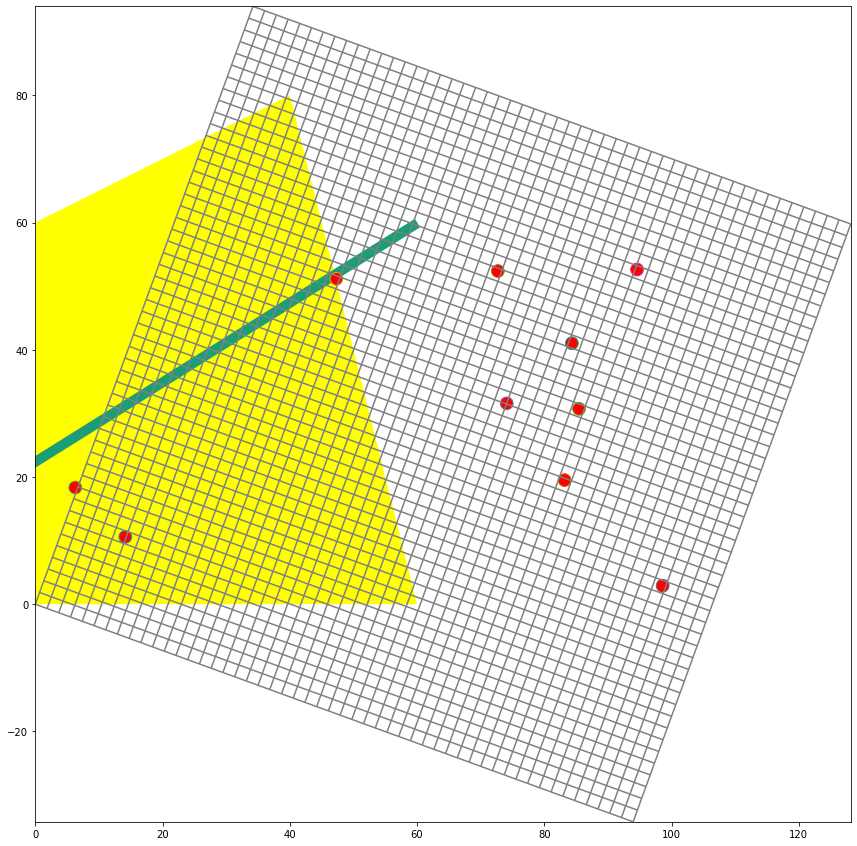

In [11]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = flopy.plot.PlotMapView(model=ms)
mm.plot_grid()
flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor='yellow', edgecolor='none')
flopy.plot.plot_shapefile(rf1shp, ax=ax, linewidth=10)
flopy.plot.plot_shapefile(rf0shp, ax=ax, facecolor='red', radius=1)

### Build the Grid

In [12]:
g.build(verbose=False)

### Plot the Grid

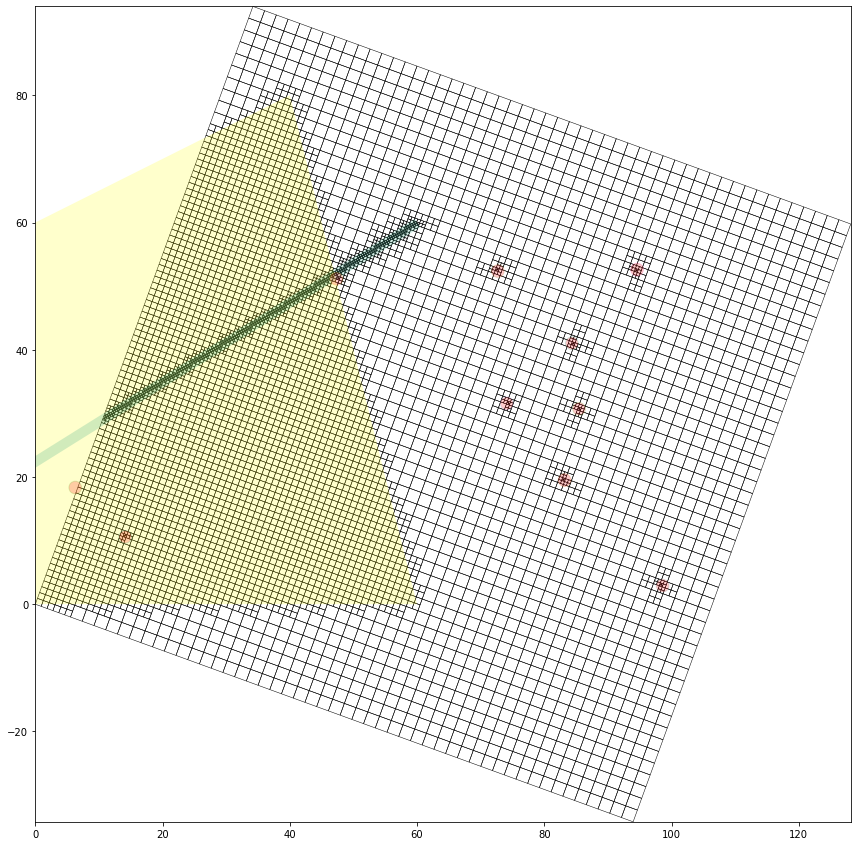

In [13]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, linewidth=0.5)
flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor='yellow', edgecolor='none', alpha=0.2)
flopy.plot.plot_shapefile(rf1shp, ax=ax, linewidth=10, alpha=0.2)
flopy.plot.plot_shapefile(rf0shp, ax=ax, facecolor='red', radius=1, alpha=0.2)

### Create a Flopy ModflowDisu Object

In [14]:
mu = flopy.modflow.Modflow(model_ws=gridgen_ws, modelname='mfusg')
disu = g.get_disu(mu)
disu.write_file()
# print(disu)

### Intersect Features with the Grid

In [15]:
adpoly_intersect = g.intersect(adpoly, 'polygon', 0)
print(adpoly_intersect.dtype.names)
print(adpoly_intersect)
print(adpoly_intersect.nodenumber)

('nodenumber', 'polyid', 'totalarea', 'SHAPEID')
[( 322, 0, 0.961169 , 0) ( 382, 0, 0.961169 , 0) ( 325, 0, 0.961169 , 0)
 ... (3275, 0, 0.834025 , 0) (3276, 0, 0.0454391, 0)
 (3278, 0, 0.567496 , 0)]
[ 322  382  325 ... 3275 3276 3278]


In [16]:
well_intersect = g.intersect(wells, 'point', 0)
print(well_intersect.dtype.names)
print(well_intersect)
print(well_intersect.nodenumber)

('nodenumber', 'pointid', 'SHAPEID')
[(5396, 0, 0) (1490, 1, 1) (3133, 2, 2) (2358, 3, 3) ( 582, 4, 4)
 (2198, 6, 6) (1739, 7, 7) (1049, 8, 8) (3955, 9, 9)]
[5396 1490 3133 2358  582 2198 1739 1049 3955]


In [17]:
river_intersect = g.intersect(river, 'line', 0)
print(river_intersect.dtype.names)
# print(river_intersect)
# print(river_intersect.nodenumber)

('nodenumber', 'arcid', 'length', 'starting_distance', 'ending_distance', 'SHAPEID')


### Plot Intersected Features

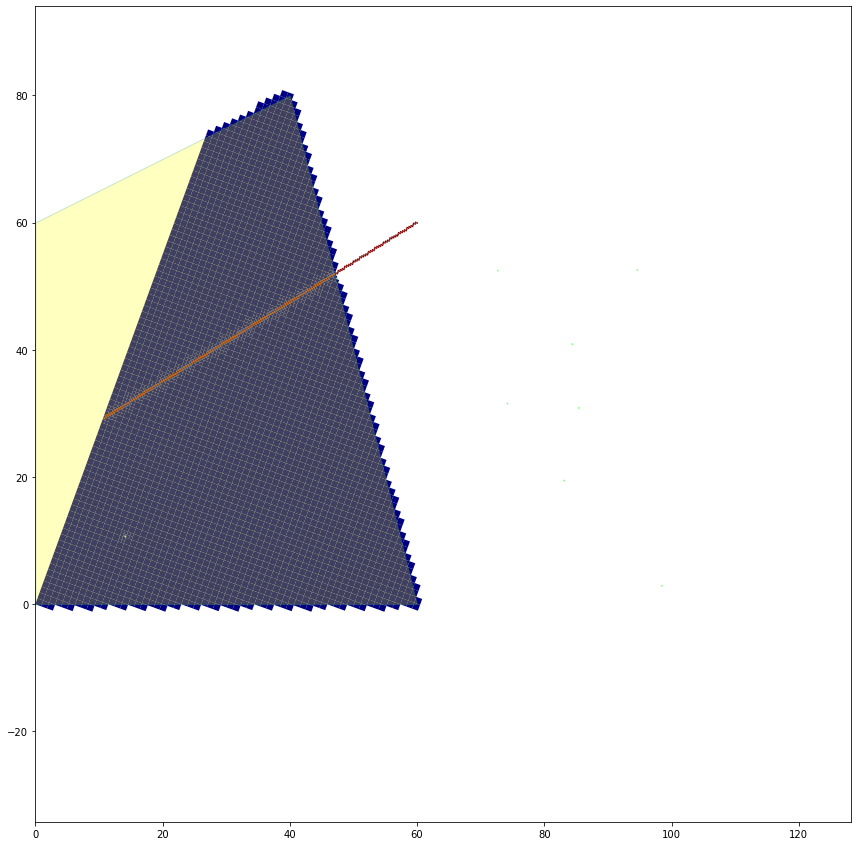

In [18]:
a = np.zeros((g.nodes), dtype=int)
a[adpoly_intersect.nodenumber] = 1
a[well_intersect.nodenumber] = 2
a[river_intersect.nodenumber] = 3
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
g.plot(ax, a=a, masked_values=[0], edgecolor='none', cmap='jet')
flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor='yellow', alpha=0.25)

## Use Gridgen to Build MODFLOW 6 DISV Model

In this section, we will reproduce the MODFLOW 6 Quick Start example that is shown on the main page of the flopy repository (https://github.com/modflowpy/flopy).

A main idea for DISV in MODFLOW 6 is that each layer much have the same spatial grid.  Gridgen allows the creation of a grid that has a different number of cells within each layer.  This type of grid cannot be used with the DISV Package.  To make sure that the resulting grid is the same for each layer, refinement should be added to all layers when using the flopy Gridgen wrapper.

In [19]:
from shapely.geometry import Polygon
name = 'dummy'
nlay = 3
nrow = 10
ncol = 10
delr = delc = 1.
top = 1
bot = 0
dz = (top - bot) / nlay
botm = [top - k * dz for k in range(1, nlay + 1)]

# Create a dummy model and regular grid to use as the base grid for gridgen
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=gridgen_ws, exe_name='mf6')
gwf = flopy.mf6.ModflowGwf(sim, modelname=name)

dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, 
                              delr=delr, delc=delc,
                              top=top, botm=botm)

# Create and build the gridgen model with a refined area in the middle
g = Gridgen(dis, model_ws=gridgen_ws)
polys = [Polygon([(4, 4), (6, 4), (6, 6), (4, 6)])]
g.add_refinement_features(polys, 'polygon', 3, range(nlay))
g.build()

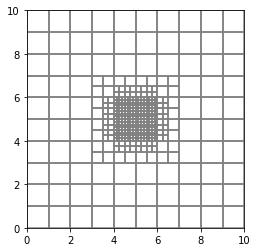

In [20]:
# Create and plot a flopy VertexGrid object
# Note that this is not necessary, because it can
# be created automatically after the disv package
# is added to the gwf model (gwf.modelgrid should exist)
gridprops_vg = g.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops_vg)
vgrid.plot()

In [21]:
# retrieve a dictionary of arguments to be passed
# directly into the flopy disv constructor
disv_gridprops = g.get_gridprops_disv()
disv_gridprops.keys()

dict_keys(['nlay', 'ncpl', 'top', 'botm', 'nvert', 'vertices', 'cell2d'])

In [22]:
# find the cell numbers for constant heads
chdspd = []
ilay = 0
for x, y, head in [(0, 10, 1.), (10, 0, 0.)]:
    ra = g.intersect([(x, y)], 'point', ilay)
    ic = ra['nodenumber'][0]
    chdspd.append([(ilay, ic), head])
chdspd

[[(0, 0), 1.0], [(0, 435), 0.0]]

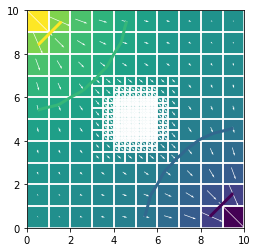

In [23]:
# build run and post-process the MODFLOW 6 model
ws = os.path.join(model_ws, 'gridgen_disv')
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6', 
                             verbosity_level=0)
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, linear_acceleration='bicgstab')
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
disv = flopy.mf6.ModflowGwfdisv(gwf, **disv_gridprops)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=True,
                              save_specific_discharge=True)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation(silent=True)
head = gwf.output.head().get_data()
bud = gwf.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]

pmv = flopy.plot.PlotMapView(gwf)
pmv.plot_array(head)
pmv.plot_grid(colors='white')
pmv.contour_array(head, levels=[.2, .4, .6, .8], linewidths=3.)
pmv.plot_vector(spdis["qx"], spdis["qy"], color='white')

## Use Gridgen to Build MODFLOW 6 DISU Model

In this section, we will reproduce the MODFLOW 6 Quick Start example that is shown on the main page of the flopy repository (https://github.com/modflowpy/flopy).

DISU is the most general grid form that can be used with MODFLOW 6.  It does not have the requirement that each layer must use the same grid

In [24]:
from shapely.geometry import Polygon
name = 'dummy'
nlay = 3
nrow = 10
ncol = 10
delr = delc = 1.
top = 1
bot = 0
dz = (top - bot) / nlay
botm = [top - k * dz for k in range(1, nlay + 1)]

# Create a dummy model and regular grid to use as the base grid for gridgen
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=gridgen_ws, exe_name='mf6')
gwf = flopy.mf6.ModflowGwf(sim, modelname=name)

dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, 
                              delr=delr, delc=delc,
                              top=top, botm=botm)

# Create and build the gridgen model with a refined area in the middle
g = Gridgen(dis, model_ws=gridgen_ws)
polys = [Polygon([(4, 4), (6, 4), (6, 6), (4, 6)])]
g.add_refinement_features(polys, 'polygon', 3, layers=[0])
g.build()

In [25]:
# retrieve a dictionary of arguments to be passed
# directly into the flopy disu constructor
disu_gridprops = g.get_gridprops_disu6()
disu_gridprops.keys()

dict_keys(['nodes', 'top', 'bot', 'area', 'iac', 'nja', 'ja', 'cl12', 'ihc', 'hwva', 'angldegx', 'nvert', 'vertices', 'cell2d'])

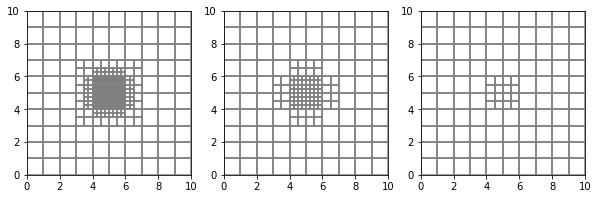

In [26]:
# Create and plot a flopy UnstructuredGrid object
gridprops_ug = g.get_gridprops_unstructuredgrid()
ugrid = flopy.discretization.UnstructuredGrid(**gridprops_ug)

f = plt.figure(figsize=(10, 10))
for ilay in range(g.nlay):
    ax = plt.subplot(1, g.nlay, ilay + 1)
    ugrid.plot(layer=ilay, ax=ax)

In [27]:
# find the cell numbers for constant heads
chdspd = []
for x, y, head in [(0, 10, 1.), (10, 0, 0.)]:
    ra = g.intersect([(x, y)], 'point', 0)
    ic = ra['nodenumber'][0]
    chdspd.append([(ic,), head])
chdspd

[[(0,), 1.0], [(435,), 0.0]]

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package disu...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...


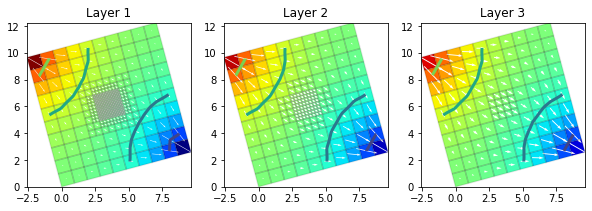

In [28]:
# build run and post-process the MODFLOW 6 model
ws = os.path.join(model_ws, 'gridgen_disu')
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6', 
                             verbosity_level=1)
tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(sim, linear_acceleration='bicgstab')
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
disu = flopy.mf6.ModflowGwfdisu(gwf, **disu_gridprops)
ic = flopy.mf6.ModflowGwfic(gwf)
npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=True,
                              save_specific_discharge=True)
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
budget_file = name + '.bud'
head_file = name + '.hds'
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=budget_file,
                            head_filerecord=head_file,
                            saverecord=[('HEAD', 'ALL'), 
                                        ('BUDGET', 'ALL')])
sim.write_simulation()
sim.run_simulation(silent=True)
head = gwf.output.head().get_data()
bud = gwf.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]

gwf.modelgrid.set_coord_info(angrot=15)

f = plt.figure(figsize=(10, 10))
vmin = head.min()
vmax = head.max()
for ilay in range(gwf.modelgrid.nlay):
    ax = plt.subplot(1, g.nlay, ilay + 1)
    pmv = flopy.plot.PlotMapView(gwf, layer=ilay, ax=ax)
    ax.set_aspect('equal')
    pmv.plot_array(head.flatten(), cmap='jet', vmin=vmin, vmax=vmax)
    pmv.plot_grid(colors='k', alpha=0.1)
    pmv.contour_array(head, levels=[.2, .4, .6, .8], linewidths=3., vmin=vmin, vmax=vmax)
    ax.set_title("Layer {}".format(ilay + 1))
    pmv.plot_vector(spdis["qx"], spdis["qy"], color='white')

## Use Gridgen to Build MODFLOW-USG DISU Model

In this section, we will reproduce the MODFLOW 6 Quick Start example that is shown on the main page of the flopy repository (https://github.com/modflowpy/flopy).

In this last example, MODFLOW-USG will be used to simulate the problem.

FloPy is using the following executable to run the model: /Users/jdhughes/.local/bin/mfusg

                                  MODFLOW-USG      
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER FLOW MODEL
                             Version 1.5.00 02/27/2019                       

 Using NAME file: mymodel.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/08/16 14:51:29

 Solving:  Stress period:     1    Time step:     1    Groundwater Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/08/16 14:51:29
 Elapsed run time:  0.019 Seconds

  Normal termination of simulation


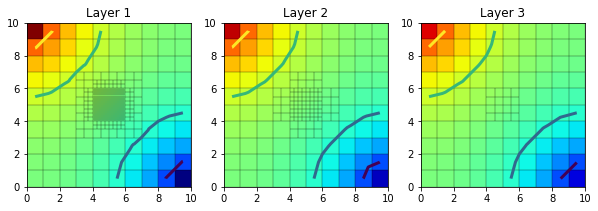

In [29]:
# build run and post-process the MODFLOW 6 model
ws = os.path.join(model_ws, 'gridgen_mfusg')
name = 'mymodel'

chdspd = []
for x, y, head in [(0, 10, 1.), (10, 0, 0.)]:
    ra = g.intersect([(x, y)], 'point', 0)
    ic = ra['nodenumber'][0]
    chdspd.append([ic, head, head])

gridprops = g.get_gridprops_disu5()

# create the mfusg modoel
m = flopy.modflow.Modflow(modelname=name, model_ws=ws,
                          version='mfusg', exe_name='mfusg',
                          structured=False)
disu = flopy.modflow.ModflowDisU(m, **gridprops)
bas = flopy.modflow.ModflowBas(m)
lpf = flopy.modflow.ModflowLpf(m)
chd = flopy.modflow.ModflowChd(m, stress_period_data=chdspd)
sms = flopy.modflow.ModflowSms(m)
oc = flopy.modflow.ModflowOc(m)
m.write_input()
m.run_model()

# head is returned as a list of head arrays for each layer
head_file = os.path.join(ws, name + '.hds')
head = flopy.utils.HeadUFile(head_file).get_data()

# MODFLOW-USG does not have vertices, so we need to create
# and unstructured grid and then assign it to the model. This
# will allow plotting and other features to work properly.
gridprops_ug = g.get_gridprops_unstructuredgrid()
ugrid = flopy.discretization.UnstructuredGrid(**gridprops_ug)
m.modelgrid = ugrid

f = plt.figure(figsize=(10, 10))
vmin = 0.
vmax = 1.
for ilay in range(disu.nlay):
    ax = plt.subplot(1, g.nlay, ilay + 1)
    pmv = flopy.plot.PlotMapView(m, layer=ilay, ax=ax)
    ax.set_aspect('equal')
    pmv.plot_array(head[ilay], cmap='jet', vmin=vmin, vmax=vmax)
    pmv.plot_grid(colors='k', alpha=0.1)
    pmv.contour_array(head[ilay], levels=[.2, .4, .6, .8], linewidths=3.)
    ax.set_title("Layer {}".format(ilay + 1))